## Exploration of LIME with LeafSnap dataset
[LIME paper](https://arxiv.org/abs/1602.04938)  
LIME is implemented in several packages. Here we use the reference implementation by the author: https://github.com/marcotcr/lime

The steps in this notebook are:
- Load LeafSnap ONNX model
- Run test set through model and generate confusion matrix
- Select image to run LIME on
- Create heatmap of LIME explanation

In [1]:
import os
import numpy as np
# import onnx
import onnxruntime as ort
import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

import torch
from torch.nn import functional as F
from torchvision import datasets, transforms
from sklearn.metrics import confusion_matrix

from lime.lime_image import LimeImageExplainer
from skimage.segmentation import mark_boundaries

np.random.seed(0)

In [2]:
# load onnx model
model_path = os.path.expanduser('~/surfdrive/Shared/datasets/leafsnap/leafsnap_model.onnx')
sess = ort.InferenceSession(model_path)
input_name = sess.get_inputs()[0].name
output_name = sess.get_outputs()[0].name

In [3]:
# load data
dataset_root = os.path.expanduser('~/projects/DIANNA/datasets/leafsnap/leafsnap-dataset-30subset')
img_size = 128
# apply same transform as during training: resize and crop to a square image, then convert to tensor
transform = transforms.Compose([transforms.Resize(img_size),
                                transforms.CenterCrop(img_size),
                                transforms.ToTensor()])

test_data = datasets.ImageFolder(os.path.join(dataset_root, 'dataset/split/test'), transform=transform,
                                 is_valid_file=lambda fname: fname.endswith('.jpg'))
nsample = len(test_data)
nspecies = len(test_data.classes)
print(f'Number of samples: {nsample}')
print(f'Number of species: {nspecies}')

Number of samples: 739
Number of species: 30


In [4]:
# run prediction
predictions = []
labels = []
for sample, label in tqdm.notebook.tqdm(test_data):
    # convert to numpy, add batch axis
    sample = sample.detach().numpy().astype(np.float32)[None, ...]
    out = sess.run([output_name], {input_name: sample})[0]
    predictions.append(np.argmax(out))
    labels.append(label)

predictions = np.array(predictions)
labels = np.array(labels)

  0%|          | 0/739 [00:00<?, ?it/s]

In [5]:
# accuracy on entire sample
accuracy = (predictions == labels).sum() / nsample
print(f'Accuracy: {accuracy*100:.2f}%')

Accuracy: 83.63%


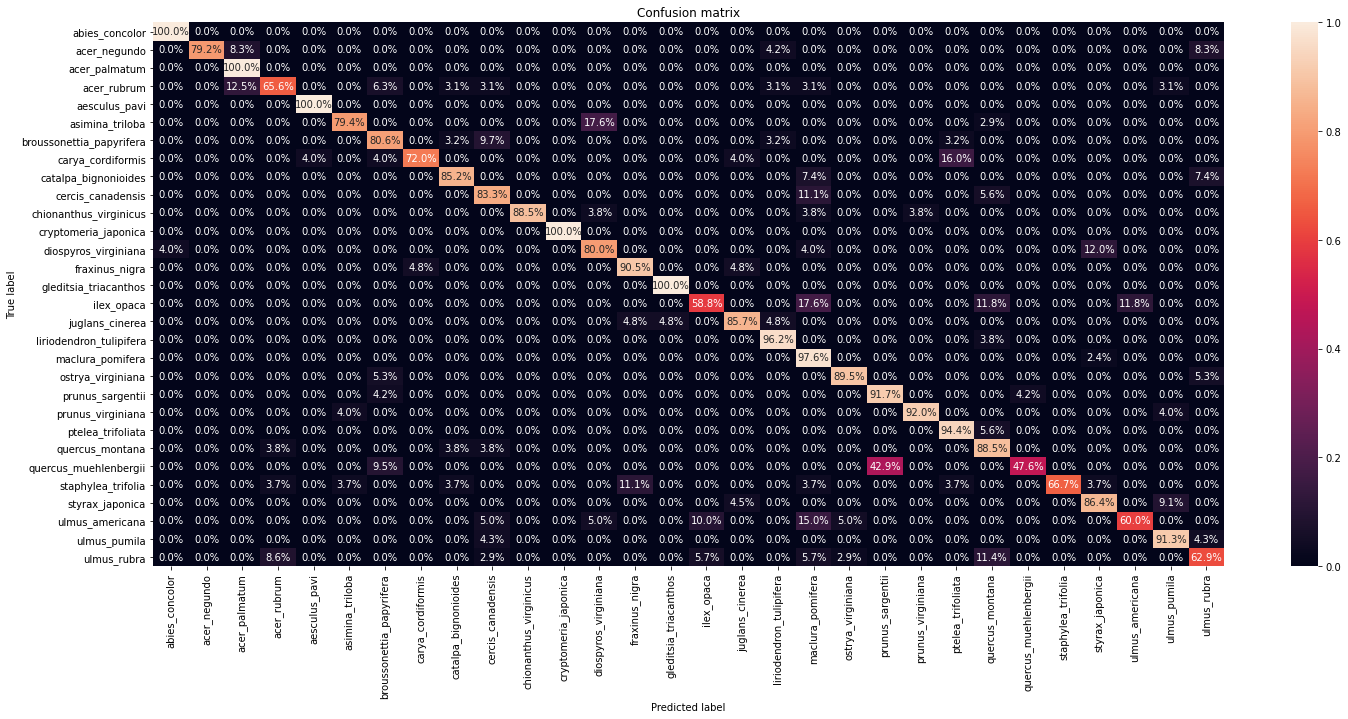

In [6]:
# confusion matrix; convert prediction to string for easier analysis
conf_mat = confusion_matrix(labels, predictions, normalize='true')
plt.figure(figsize=(24, 10))
sns.heatmap(conf_mat/conf_mat.sum(axis=1), xticklabels=test_data.classes, yticklabels=test_data.classes,
            annot=True, fmt='.1%')
plt.title('Confusion matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.savefig('leafsnap_confusion_matrix.pdf', bbox_inches='tight')

In [7]:
# Select which true and predicted species to select an image from. Note: the selected combination must exist, so no 0.0% in the confusion matrix
true_species = 'acer_rubrum'
pred_species = 'acer_rubrum'

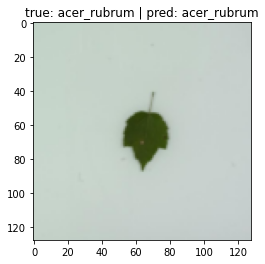

In [8]:
true_species_index = test_data.class_to_idx[true_species]
pred_species_index = test_data.class_to_idx[pred_species]

# select a random image belonging to selected species
img_index = np.random.choice(np.where((labels == true_species_index) & (predictions == pred_species_index))[0])
image, label = test_data[img_index]
# permute the image to have numpy ordering
image = image.permute(1, 2, 0).numpy().astype(np.float64)
plt.imshow(image)
plt.title(f'true: {true_species} | pred: {pred_species}');

In [9]:
# initialize LIME explainer for images
explainer = LimeImageExplainer()

In [10]:
# function to predict a batch of images in format used by LIME: float64 numpy arrays, channel last
def predict(images):
    # convert images to 32-bit floats, channel first
    images = [np.transpose(image.astype(np.float32), (2, 1, 0)) for image in images]
    # run batch of images through model
    out = sess.run([output_name], {input_name: images})[0]
    # the output are logits, use softmax to get probabilities
    return F.softmax(torch.from_numpy(out), dim=1).detach().numpy()

In [11]:
%%time
# Hide color is the color for a superpixel turned OFF. Alternatively, if it is NONE, the superpixel will be replaced by the average of its pixels
explanation = explainer.explain_instance(image, predict, labels=(true_species_index, pred_species_index), top_labels=None, hide_color=.5, distance_metric='euclidean')

  0%|          | 0/1000 [00:00<?, ?it/s]

CPU times: user 12.6 s, sys: 213 ms, total: 12.8 s
Wall time: 3.35 s


In [12]:
# extract heatmap for both true species and predicted species
img_true, mask_true = explanation.get_image_and_mask(true_species_index, positive_only=False, hide_rest=True, num_features=10)
img_pred, mask_pred = explanation.get_image_and_mask(pred_species_index, positive_only=False, hide_rest=True, num_features=10)

img_true_with_bounds = mark_boundaries(img_true, mask_true)
img_pred_with_bounds = mark_boundaries(img_pred, mask_pred)

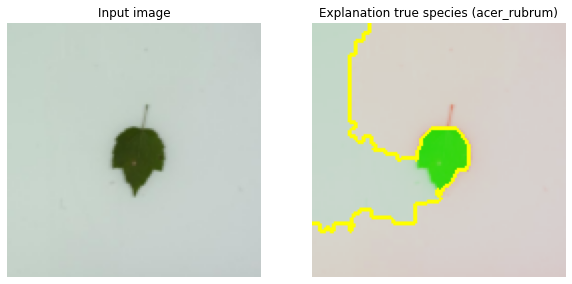

In [13]:
if pred_species == true_species:
    fig, axes = plt.subplots(figsize=(10, 6), ncols=2)
else:
    fig, axes = plt.subplots(figsize=(15, 6), ncols=3)

# plot original image
ax = axes[0]
ax.imshow(image)
ax.axis('off')
ax.set_title(f'Input image')

# heatmap for true species
ax = axes[1]
ax.imshow(img_true_with_bounds)
ax.axis('off')
ax.set_title(f'Explanation true species ({true_species})')

# heatmap for predicted species
if pred_species != true_species:
    ax = axes[2]
    ax.imshow(img_pred_with_bounds)
    ax.axis('off')
    ax.set_title(f'Explanation predicted species ({pred_species})')
    
fig.savefig('leafsnap_lime.pdf', bbox_inches='tight')